In [1]:
%load_ext autoreload
%autoreload 2
import time
start_time = time.time()

import json
import numpy as np
import csv

import sys
sys.path.append("../libraries/")
from selector import split_data

In [2]:
#########################
### Utility Functions ###
#########################

# searches for first match to target in dat, beginning
# search at start_offset
# useful for searching sorted lists.
def linearSearch(dat, target, start_offset=0):
    for i in range(start_offset, len(dat)):
        if target == dat[i]:
            return i
    

# takes n x 1 vectors of prsn_ratings and matching prsn_id,
# and an m x 1 (n >= m) vector of uniq_prsn_ids for whom we
# want to get average X. Does not preserve order.
# returns new uniq_lbls corresponding to order of avg_X
# O( n log(n) )
#
# if laplaceSmoothing is used then we add alpha to numerator
# and alpha*d to the denominator. If empirical distribution
# is known you can specify empirical distribution of category
# using mu. Mu can be a vector of length m if X is n x m
def avgByLbl(X, lbls):    
    # sort data for efficient averaging
    dat = sorted(list(zip(X,lbls)), key=lambda id: id[1])
    dat = [[i for i,j in dat], [j for i,j in dat]]
    X = np.array(dat[0])
    lbls = dat[1]
    
    uniq_lbls = np.unique(lbls)
    uniq_lbls = sorted(uniq_lbls)
    
    # use an averaging algorithm optimized for sorted entries
    # (requires sorted search targets and search list)
    # this algorithm never traverses the same element of the
    # search list twice, but carries the overhead of a pre-
    # sorted target list and search list. Thankfully those
    # can use the O(n log(n)) python sort implementation
    idx = 0
    
    if len(X.shape) > 1:
        avg_X = np.zeros((len(uniq_lbls),len(X[0])))
        for i,this_id in enumerate(uniq_lbls):
            idx = linearSearch(lbls, this_id, idx)
            n = 0.0
            while idx < len(lbls) and lbls[idx] == this_id:
                avg_X[i] = np.sum(np.vstack([avg_X[i],X[idx]]),axis=0)
                n += 1.0
                idx += 1
            avg_X[i] /= n
    else: 
        avg_X = np.zeros(len(uniq_lbls))
        for i,this_id in enumerate(uniq_lbls):
            idx = linearSearch(lbls, this_id, idx)
            n = 0.0
            while idx < len(lbls) and lbls[idx] == this_id:
                avg_X[i] += X[idx]
                n += 1.0
                idx += 1
            avg_X[i] /= n
            
    return avg_X, uniq_lbls

# computes expected rating based on probability of each class label
def expRating(prob):
    n,m = np.shape(prob)
    values = [1,2,3,4,5]
    values = np.tile(values,n).reshape(n,m)
    exp_val = np.sum(np.multiply(prob, values), axis=1)
    return exp_val

#########################
### Utility Functions ###
#########################

# searches for first match to target in dat, beginning
# search at start_offset
# useful for searching sorted lists.
def linearSearch(dat, target, start_offset=0):
    for i in range(start_offset, len(dat)):
        if target == dat[i]:
            return i
    

# takes n x 1 vectors of prsn_ratings and matching prsn_id,
# and an m x 1 (n >= m) vector of uniq_prsn_ids for whom we
# want to get average X. Does not preserve order.
# returns new uniq_lbls corresponding to order of avg_X
# O( n log(n) )
#
# if laplaceSmoothing is used then we add alpha to numerator
# and alpha*d to the denominator. If empirical distribution
# is known you can specify empirical distribution of category
# using mu. Mu can be a vector of length m if X is n x m
def avgByLbl(X, lbls):    
    # sort data for efficient averaging
    dat = sorted(list(zip(X,lbls)), key=lambda id: id[1])
    dat = [[i for i,j in dat], [j for i,j in dat]]
    X = np.array(dat[0])
    lbls = dat[1]
    
    uniq_lbls = np.unique(lbls)
    uniq_lbls = sorted(uniq_lbls)
    
    # use an averaging algorithm optimized for sorted entries
    # (requires sorted search targets and search list)
    # this algorithm never traverses the same element of the
    # search list twice, but carries the overhead of a pre-
    # sorted target list and search list. Thankfully those
    # can use the O(n log(n)) python sort implementation
    idx = 0
    
    if len(X.shape) > 1:
        avg_X = np.zeros((len(uniq_lbls),len(X[0])))
        for i,this_id in enumerate(uniq_lbls):
            idx = linearSearch(lbls, this_id, idx)
            n = 0.0
            while idx < len(lbls) and lbls[idx] == this_id:
                avg_X[i] = np.sum(np.vstack([avg_X[i],X[idx]]),axis=0)
                n += 1.0
                idx += 1
            avg_X[i] /= n
    else: 
        avg_X = np.zeros(len(uniq_lbls))
        for i,this_id in enumerate(uniq_lbls):
            idx = linearSearch(lbls, this_id, idx)
            n = 0.0
            while idx < len(lbls) and lbls[idx] == this_id:
                avg_X[i] += X[idx]
                n += 1.0
                idx += 1
            avg_X[i] /= n
            
    return avg_X, uniq_lbls

# takes list of text fields (e.g. summary or reviewText fields) and
# tokenizes, removes stop words and stems. Returns result as array of 
# lists, one list per review
def preprocess_data(doc_set):    
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        if not i:
            i = ' '
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        tokens.append('null__') # add a bias term, will work as a kind of prior, important for empty reviews
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

# takes an array of lists as input, product labels, uniq_labels, and ratings,
# and merges lists with matching labels among labels uniq_labels, averages
# reviews belonging to the same, returns merged lists, and averaged ratings
# uniq_labels should typically be np.unique(product labels), however 
# the option of specifying a subset is useful for parallelization to allow
# different subsets to be processed by different engines
def combine_reviews(text, asins):
        products = [asins[0]]
        combined_text = [text[0]]

        #combine all the summaries into a single text and avg the review ratings for each product
        for i in range(1, len(asins)):
            last_element_index = len(products) - 1
            if(asins[i] == products[last_element_index]):
                combined_text[last_element_index] = combined_text[last_element_index] + text[i]
                
            else:
                products.append(asins[i])
                combined_text.append(text[i])
        
        return (combined_text, products)

In [23]:
# searches for first match to target in dat, beginning
# search at start_offset
# useful for searching sorted lists.
def linearSearch(dat, target, start_offset=0):
    for i in range(start_offset, len(dat)):
        if target == dat[i]:
            return i

# takes n x 1 vectors of prsn_ratings and matching prsn_id,
# and an m x 1 (n >= m) vector of uniq_prsn_ids for whom we
# want to get average X. Does not preserve order.
# returns new uniq_lbls corresponding to order of avg_X
# O( n log(n) )
#
# if laplaceSmoothing is used then we add alpha to numerator
# and alpha*d to the denominator. If empirical distribution
# is known you can specify empirical distribution of category
# using mu. Mu can be a vector of length m if X is n x m
def avgByLbl(X, lbls):    
    # sort data for efficient averaging
    dat = sorted(list(zip(X,lbls)), key=lambda id: id[1])
    dat = [[i for i,j in dat], [j for i,j in dat]]
    X = np.array(dat[0])
    lbls = dat[1]
    
    uniq_lbls = np.unique(lbls)
    uniq_lbls = sorted(uniq_lbls)
    
    # use an averaging algorithm optimized for sorted entries
    # (requires sorted search targets and search list)
    # this algorithm never traverses the same element of the
    # search list twice, but carries the overhead of a pre-
    # sorted target list and search list. Thankfully those
    # can use the O(n log(n)) python sort implementation
    idx = 0
    avg_X = np.zeros(len(uniq_lbls))
    for i,this_id in enumerate(uniq_lbls):
        idx = linearSearch(lbls, this_id, idx)
        n = 0.0
        while idx < len(lbls) and lbls[idx] == this_id:
            avg_X[i] += X[idx]
            n += 1.0
            idx += 1
        avg_X[i] /= n

    return avg_X, uniq_lbls

def getProdRatings(target_prod_id):
    import pandas as pd

    prsn_asin = []
    prsn_id = []
    prsn_rating = []
    with open('../data/Sports_and_Outdoors_Ratings_training.csv') as file:
        reader = pd.read_csv(file, delimiter=',')
        prsn_rating = np.array([item[1] for item in reader['overall'].items()])
        prsn_id = np.array([item[1] for item in reader['reviewerID'].items()])
        prsn_asin = np.array([item[1] for item in reader['asin'].items()])

    
    prod_rating, prod_asin = avgByLbl(prsn_rating, prsn_asin)
    
    # sort prod_asin and target_prod_id so that they match
    # save inverse sort function to reverse at the end
    idx = np.argsort(target_prod_id)
    inv_sort = np.argsort(idx)
    
    target_prod_id = np.array(target_prod_id)
    target_prod_id = target_prod_id[idx]
    prod_list = sorted(list(zip(prod_rating, prod_asin)), key=lambda id: id[1])
    prod_rating = [i for i,j in prod_list]
    prod_asin = [j for i,j in prod_list]
    
    # now we can assume that prod_ratings will match target_prod_id because both prod_asin and 
    # target_prod_id are sorted
    prod_rating = [prod_rating[i] for i, this_prod in enumerate(prod_asin) if this_prod in target_prod_id] 
    prod_rating = np.array(prod_rating)
    
    # invert prod_rating to match original target_prod_rating order and return
    return prod_rating[inv_sort]


In [13]:
# import and prepare test data# Read in testing data for 80/20 split
# we won't use val_dat at all
_, val_dat = split_data('../data/Sports_and_Outdoors_Reviews_training.json', 80)

#sort test data by asin
val_dat = sorted(val_dat, key=lambda k: k['asin'])
    
doc_list = []
asin = []
rating = []
for i in range(0,len(val_dat)):
    doc_list.append(val_dat[i].get('summary'))
    rating.append(val_dat[i].get('overall'))
    asin.append(val_dat[i].get('asin'))

In [31]:
est_rating, est_lbls = avgByLbl(rating, asin)

In [ ]:
actual_rating = getProdRatings(est_lbls)

In [30]:
actual_lbl = (actual_rating) > 4.5
est_lbl = (est_rating) > 4.5

[(4.090909090909091, '00018C9635D55E22BF157AA13E91226F'),
 (3.909090909090909, '0001DE3A462B5C5D33AF3BC1053FC20C'),
 (4.3, '000F82FD8CFE81BFD75CE5081DED102D'),
 (4.857142857142857, '0010C70D31009FC965F5883B62C42C82'),
 (4.571428571428571, '00138CF1A3E0AB9CF4A2149F5A881BA5'),
 (3.8181818181818183, '00158948A61BCF6746867C026D260BA3'),
 (5.0, '001698DB4FEB1F79BEE09C40788C7002'),
 (5.0, '001DD5B55B4F4EB4A669D96865745671'),
 (4.782608695652174, '001F237E1C0B756F643EAADA1FD79C44'),
 (4.5, '001F83B563684F55ABBC381ADBEDC306'),
 (4.140350877192983, '00246ED0B1C2F3AFFFED922B43464B20'),
 (4.2, '002AD716A600C599496B2122C4A9E082'),
 (4.466666666666667, '00375675B40113499BB4332261532D9C'),
 (4.75, '0037BAC8BCBE7A5C18674734DE7C87C9'),
 (3.8181818181818183, '003853FBACA059B1A1B7E3DA9D0BEF5F'),
 (4.766666666666667, '003955AB71BE617C418EAEAC4473F73C'),
 (4.733333333333333, '004118E0C869F30DE94F9C5465C8EE22'),
 (4.384615384615385, '0045BBBF0FFAF1C6B70733D66A90F7D0'),
 (4.44, '00460B037BA9B8FA4A269E0677ED

In [26]:
from sklearn.metrics import classification_report

report = classification_report(actual_lbl, est_lbl)
print('True recall is sensitivity, false recall is specificity')
print(report)

report = classification_report(actual_lbl, np.random.permutation(est_lbl))
print('True recall is sensitivity, false recall is specificity')
print(report)

True recall is sensitivity, false recall is specificity
              precision    recall  f1-score   support

       False       0.91      0.76      0.83     10842
        True       0.65      0.85      0.74      5569

    accuracy                           0.79     16411
   macro avg       0.78      0.81      0.78     16411
weighted avg       0.82      0.79      0.80     16411

True recall is sensitivity, false recall is specificity
              precision    recall  f1-score   support

       False       0.66      0.56      0.60     10842
        True       0.34      0.44      0.38      5569

    accuracy                           0.52     16411
   macro avg       0.50      0.50      0.49     16411
weighted avg       0.55      0.52      0.53     16411



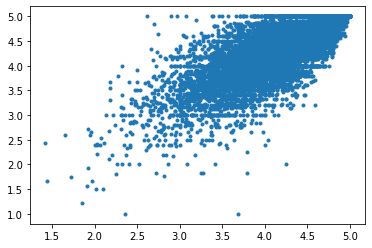

In [11]:
from matplotlib import pyplot as plt
plt.plot(actual_rating_1, est_rating_1, '.')